In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import climate_learn as cl
import numpy as np
from IPython.display import HTML

# Visualize ERA5 direct forecast
With single time-step history. Multi time-step history is shown in the next example.

In [3]:
root_dir = "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg_npz"
variables = ["2m_temperature", "temperature_850", "geopotential_500"]

In [24]:
# Direct forecasting
dm = cl.data.IterDataModule(
    "direct-forecasting",
    root_dir,
    root_dir,
    variables,
    variables,
    src="era5",
    history=1
)
dm.setup()
mm = cl.load_forecasting_module(
    data_module=dm,
    preset="persistence"
)
mm = mm.to(device="cuda:2")

Loading preset: persistence
Using preset optimizer
Using preset learning rate scheduler
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


0it [00:00, ?it/s]


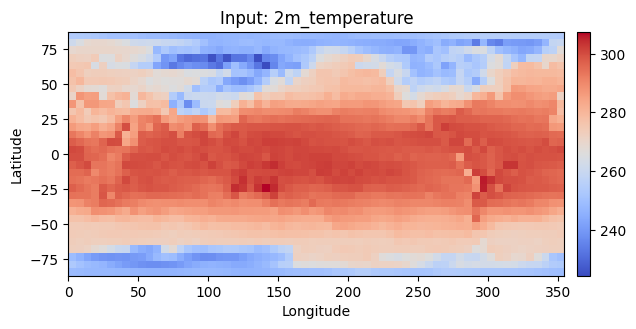

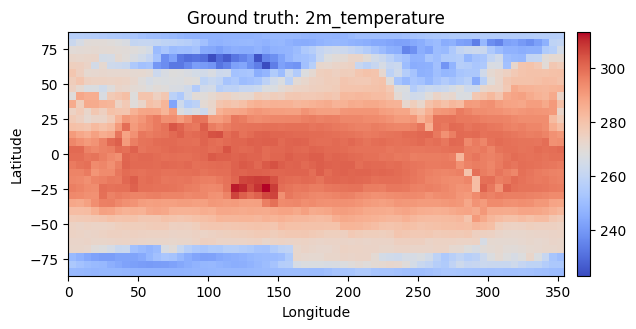

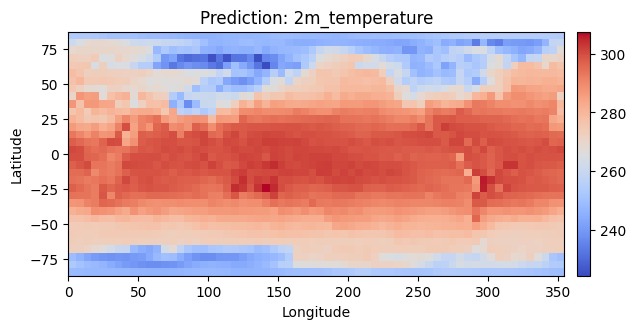

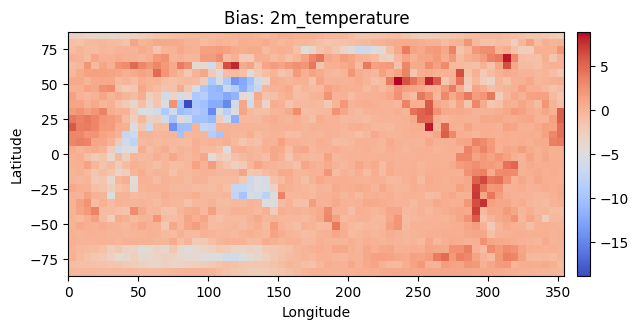

In [25]:
denorm = mm.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    mm, dm, denorm, denorm, "2m_temperature", src="era5", index=0
)

# Visualize ERA5 Continuous Forecast

In [26]:
# Continuous forecasting
dm = cl.data.IterDataModule(
    "continuous-forecasting",
    root_dir,
    root_dir,
    variables,
    variables,
    history=3
)
dm.setup()
model = cl.models.hub.ResNet(
    in_channels=4,  # 3 input variables + 1 channel for time
    out_channels=3,
    history=3,
    hidden_channels=128,
    activation="leaky",
    norm=True,
    dropout=0.1,
    n_blocks=28,
)
optimizer = cl.load_optimizer(
    model, "AdamW", {"lr": 5e-4, "weight_decay": 1e-5, "betas": (0.9, 0.99)}
)
lr_scheduler = cl.load_lr_scheduler(
    "linear-warmup-cosine-annealing",
    optimizer,
    {
        "warmup_epochs": 5,
        "max_epochs": 50,
        "warmup_start_lr": 1e-8,
        "eta_min": 1e-8,
    },
)
mm = cl.load_forecasting_module(
    data_module=dm,
    model=model,
    optim=optimizer,
    sched=lr_scheduler
)

Using custom network
Using custom optimizer
Using custom learning rate scheduler
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


0it [00:20, ?it/s]


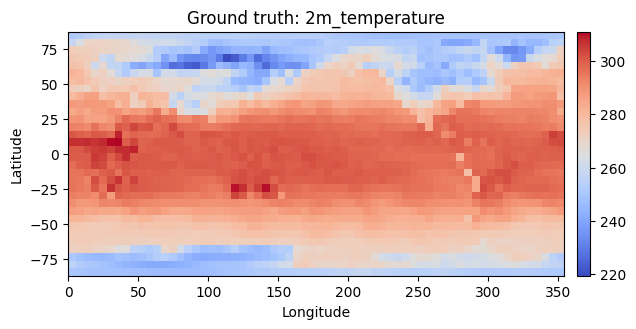

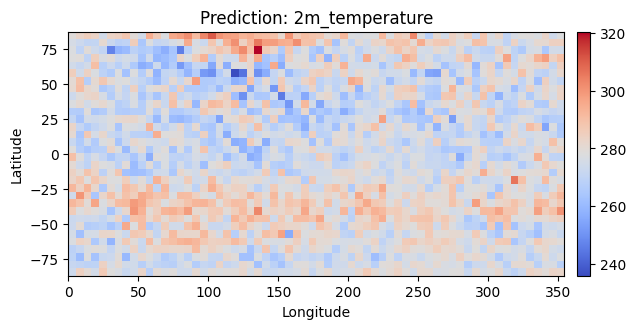

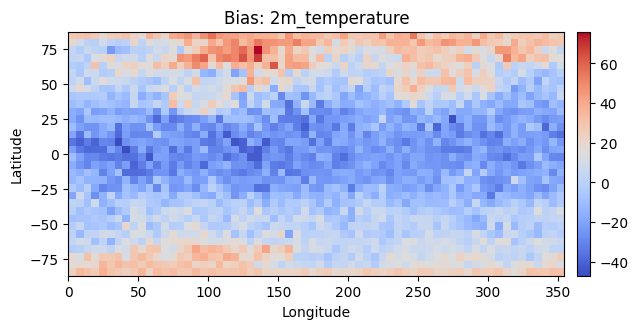

In [27]:
denorm = mm.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    mm, dm, denorm, denorm, "2m_temperature", src="era5", index=0
)

In [28]:
HTML(in_graphic.to_jshtml())

# Visualize ERA5 to PRISM downscaling

In [29]:
# Downscaling
dm = cl.data.ERA5toPRISMDataModule(
    "/data0/datasets/prism/era5_cropped",
    "/data0/datasets/prism/prism_processed"
)
dm.setup()

mask = cl.transforms.Mask(dm.get_out_mask(), val=np.nan)
denorm = cl.transforms.Denormalize(dm)
denorm_mask = lambda x: denorm(mask(x))

mm = cl.load_downscaling_module(
    data_module=dm,
    preset="bilinear-interpolation",
    train_target_transform=mask,
    val_target_transform=[denorm_mask, denorm_mask, denorm_mask, mask],
    test_target_transform=[denorm_mask, denorm_mask, denorm_mask],
)

Loading preset: bilinear-interpolation
Using preset optimizer
Using preset learning rate scheduler
Loading training loss: mse
Using custom training transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Using custom validation transform
Using custom validation transform
Using custom validation transform
Using custom validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Using custom test transform
Using custom test transform
Using custom test transform


  0%|                                                                                                                                                                  | 0/23 [00:00<?, ?it/s]


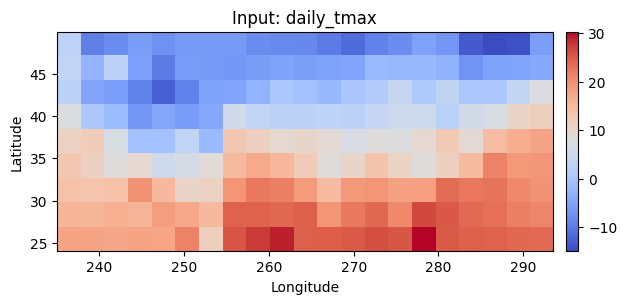

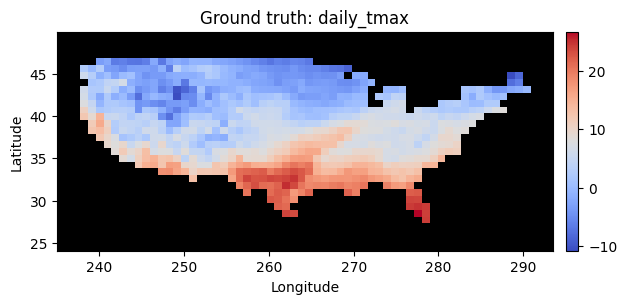

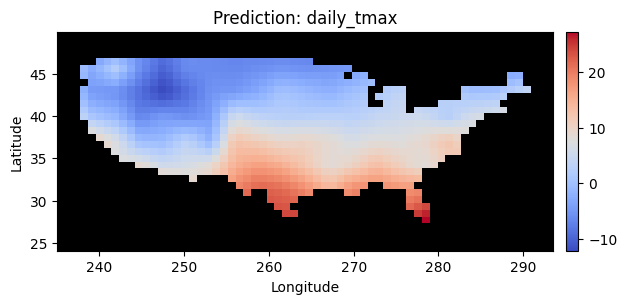

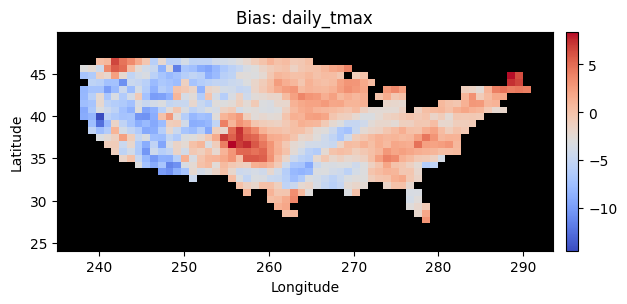

In [31]:
in_graphic = cl.utils.visualize_at_index(
    mm, dm, denorm, denorm_mask, "daily_tmax", src="era5", index=0
)

# Mean bias
For the ERA5 to PRISM downscaling case because it's the fastest, but this would work for others too.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.93it/s]


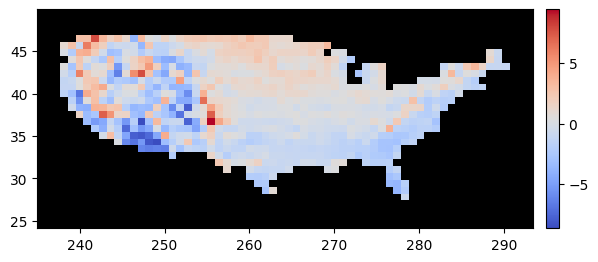

In [35]:
cl.utils.visualize_mean_bias(dm, mm, denorm_mask, "daily_tmax", "era5")